## Class 11 Agenda:
  * **Null accuracy**
  * **Confusion matrix**
  * **sensitivity, specificity, accuracy**
  * **ROC curves, AUC, setting a threshold**
  * **ROC curves, AUC: All that matters is that ordering is preserved**
  * **Pipelines: Putting your entire ML workflow together**

Today we are going to talk about how to more accurately measure models for supervised classification. Because supervised classification problems are ubiquitous (will this person churn? will this ad be clicked? will this stock go up tomorrow?), being able to evaluate how well a supervised classifier works and to be able to choose what defines a "well-performing" classifier is very important.

To that end, we will also learn how to:
  * decompose the kinds of errors a trained model makes (on unseen data)
  * decide where (at what probability) to threshold a binary classifier (one that decides between two choices) given what is acceptable in terms of the kinds of errors the model is expected to make in the wild. 
  * understand confusion matrices
  
** By the end of this notebook you will:**

- Have a working conceptual understanding of key aspects of model evaluation in machine learning
- Be able to interpret key model metrics computed using scikit-learn
- Be able to to use different model metrics for model evaluation, depending on the goals of your model
- Be able to explain what an ROC curve and AUC metric are and how they should be used when evaluating classifiers and setting classifier thresholds.

Let's import everything we're going to use today, like always:

In [1]:
from __future__ import print_function

import warnings

warnings.filterwarnings("ignore")

In [2]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn import metrics
import scipy.stats as stats

# visualization
%matplotlib inline
import seaborn as sns

### Null Accuracy

Null accuracy measures what our expected accuracy should be if we were to **use the most frequent response (most frequent class) as our prediction for every new sample we see.** It is a baseline against which you may want to measure your classifier, especially when your classes are really unbalanced.

In class 5, when we learned about [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression), we attempted to build a predictive model on a dataset that was fairly unbalanced (the vertebral column dataset from UCI).

Let's use that dataset again to measure null accuracy, and see whether a basic Logistic Regression model can give higher test set accuracy than this:

In [3]:
vertebral_data = pd.read_csv("../data/vertebral_column_2_categories.dat",sep=" ", 
                             names=["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle",
                                    "sacral_slope","pelvic_radius","spondy_grade","outcome"])
vertebral_data.outcome.value_counts()
vertebral_data.outcome = (vertebral_data.outcome =="AB").astype(int)
X = vertebral_data[vertebral_data.columns.tolist()[:-1]]
y = vertebral_data.outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

lr = LogisticRegression(C=1e9)   # we build a very basic logistic regression model here
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)

print("Test set accuracy of LR model: ",metrics.accuracy_score(y_test, y_test_pred))

Test set accuracy of LR model:  0.870967741935


**What is the null accuracy here?**

It is simply the fraction of `AB` (class 1) samples in the test set (since that is the most frequent class in the whole dataset):

In [4]:
# compute null accuracy manually
print("Null accuracy on the test set: ",y_test.mean())

Null accuracy on the test set:  0.709677419355


We can compute this using the scikit-learn api by creating what's called a `DummyClassifier`.

It can create a variety of dummy models based on simple statistics it is trained on.

We are going to create one where the model simply predicts the most frequent class, by passing in a `string` to the `strategy` parameter when we generate the unfitted model: 

In [5]:
from sklearn.dummy import DummyClassifier
dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))

Most frequent class dummy classifier test accuracy:  0.709677419355


#### Exercise Time

* Use the same dummy classifier approach and train an LR model using 10-fold cross validation and compute the accuracy score of each model.
* Do the same with 30-fold cross validation and plot both test-set accuracy distributions. Are the two distributions overlapping? If they aren't what does that mean?

(0, 1)

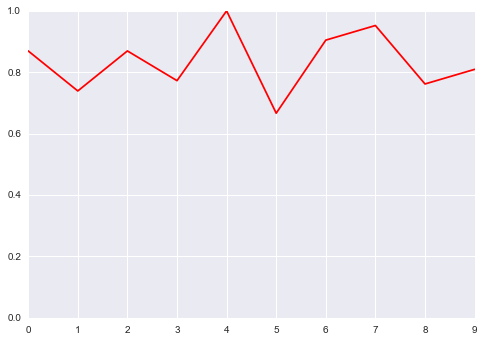

In [10]:
# pass
import matplotlib.pyplot as plt
lr = LogisticRegression(C=1e9)   # we build a very basic logistic regression model here
scores = cross_val_score(lr, X_train,y_train, cv=10)
plt.plot(range(10), scores, 'r-')
plt.ylim([0,1])





### Confusion Matrix

In order to more fully understand the kinds of mistakes the model is making, we need to investigate what is called the **confusion matrix** of the model on unseen (test) data. The confusion matrix simply counts the number of predictions that fall into each possible prediction bucket.

So, for a 2-class classification problem, there are 4 "prediction buckets":
  * predict 0 (normal), actual 0 (normal) - called a **correct rejection/true negative**
  * predict 0 (normal), actual 1 (abnormal) <-- this is an error called a **miss/false negative**
  * predict 1 (abnormal), actual 0 (normal) <-- this is an error called a **false alarm/false positive**
  * predict 1 (abnormal), actual 1 (abnormal) - called a **hit/true positive**
  
![confusion matrix](../images/confusion_matrix.png)

Let's compute the confusion matrix on the test set for our Logistic Regression model:

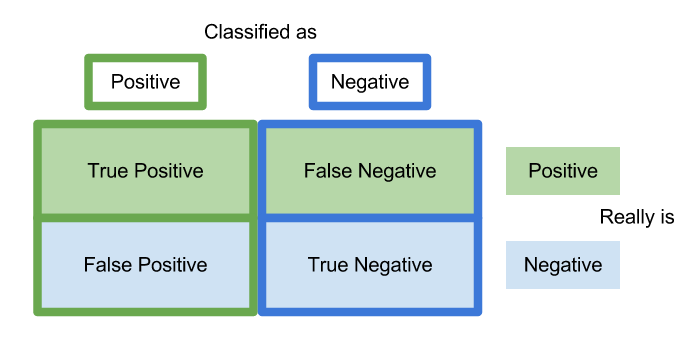

In [21]:
from IPython.display import Image
Image(filename = '../images/confusion_matrix.png')

In [20]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)
print(cm)


[[21  6]
 [ 6 60]]


By convention in a confusion matrix, the actual categories are the rows and the predicted values are the columns. Our confusion matrix shows that on the test set we have an equal number of misses and false alarms (both values are 6).

We can break down the confusion matrix into a variety of single-value metrics that answer specific questions about how our model is expected to fare on new data:

  * **sensitivity/true positive rate(TPR)/recall:** What fraction of the "abnormal" samples in unseen data did we correctly predict? 
  $$ TPR = \frac {\sum TP}{\sum (TP+FN)}$$
  * **specificity/true negative rate(TNR):** What fraction of "normal" samples in unseen data did we correctly predict?  
  $$ TNR = \frac {\sum TN}{\sum (TN+FP)}$$
  * **precision/positive predictive value(PPV)** How frequently is our model correct when it predicts "abnormal" on new data?
  $$ PPV = \frac {\sum TP}{\sum (TP+FP)}$$
  * **negative predictive value (NPV):** How frequently is our model correct when it predicts "normal" on new data? 
  $$ NPV = \frac {\sum TN}{\sum (TN+FN)}$$
  * **accuracy (ACC):** How frequently is our model correct on all new data, regardless of class?
  $$ ACC = \frac {\sum (TN+TP)}{\sum (TN+FN+TP+FP)}$$
  * **F1 score (F1): ** The harmonic mean of precision and recall:
  $$ F1 = 2*\frac {Precision*Recall}{Precision+Recall}$$

In [22]:
# calculate each metric by hand
print("Sensitivity/Recall (TPR): ",cm[1,1] / float(cm[1,1] + cm[1,0]))
print("Specificity (TNR): ", cm[0,0] / float(cm[0,0] + cm[0,1]))
print("Precision (PPV): ", cm[1,1] / float(cm[1,1]+cm[0,1]))
print("NPV: ", cm[0,0] / float(cm[0,0]+cm[1,0]))
print("Accuracy: ", (cm[1,1]+cm[0,0]) / float(cm.sum()))
print("F1:", metrics.f1_score(y_test,y_test_pred))

Sensitivity/Recall (TPR):  0.909090909091
Specificity (TNR):  0.777777777778
Precision (PPV):  0.909090909091
NPV:  0.777777777778
Accuracy:  0.870967741935
F1: 0.909090909091


In [23]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred))
print("Accuracy: ", metrics.accuracy_score(y_test,y_test_pred))
print("F1:", metrics.f1_score(y_test,y_test_pred))

Sensitivity/Recall (TPR):  0.909090909091
Precision (PPV):  0.909090909091
Accuracy:  0.870967741935
F1: 0.909090909091


Or we can compute the full classification report, which will give us precision/recall per-feature:

In [24]:
print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))

Classification Report:
              precision    recall  f1-score   support

          0       0.78      0.78      0.78        27
          1       0.91      0.91      0.91        66

avg / total       0.87      0.87      0.87        93



### ROC Curves and AUC

So far, we've working with the thresholded decisions a given classifier/model makes when it outputs a prediction (all we've been looking at is the predicted category of trained models). 

However, many classifiers (including both **logistic regression** and **random forest** models) can output a "confidence" associated with their prediction (this is called a **prediction probability**). 

Let's take a look at the prediction probabilites and the predictions of our original logistic regression classifier on our single test set:

In [25]:

lr.fit(X_train,y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
lr.predict_proba(X_test)[:10]   # we use this probability outcome to plot the ROC curve

array([[  1.80102880e-02,   9.81989712e-01],
       [  1.10839051e-01,   8.89160949e-01],
       [  1.05363671e-02,   9.89463633e-01],
       [  9.37351114e-02,   9.06264889e-01],
       [  9.74406164e-03,   9.90255938e-01],
       [  4.12698411e-02,   9.58730159e-01],
       [  7.92601716e-01,   2.07398284e-01],
       [  1.93907940e-04,   9.99806092e-01],
       [  5.93307002e-04,   9.99406693e-01],
       [  4.78995202e-01,   5.21004798e-01]])

In [27]:
#lr probabilities per category for first five samples
predicted_probs_lr = lr.predict_proba(X_test).round(3)
predictions_lr = lr.predict(X_test)

print("Logistic Regression predicted probabilities for first five samples in test set:\n",predicted_probs_lr[:5])
print("Logistic Regression predictions for first five samples in test set:\n",predictions_lr[:5])
y_test_lr_df = pd.DataFrame(
    np.concatenate((
        predicted_probs_lr,predictions_lr.reshape((predictions_lr.shape[0],-1)),
        y_test.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

y_test_lr_df.head()

Logistic Regression predicted probabilities for first five samples in test set:
 [[ 0.018  0.982]
 [ 0.111  0.889]
 [ 0.011  0.989]
 [ 0.094  0.906]
 [ 0.01   0.99 ]]
Logistic Regression predictions for first five samples in test set:
 [1 1 1 1 1]


,class_0,class_1,predicted,actual
0,0.018,0.982,1.0,1.0
1,0.111,0.889,1.0,0.0
2,0.011,0.989,1.0,1.0
3,0.094,0.906,1.0,1.0
4,0.010,0.990,1.0,1.0


Lets generate the same table of predicted probabilities, predictions, and actual values, for a trained random forest classifier that contains 100 trees:

In [28]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

predicted_probs_rf = rf.predict_proba(X_test)
predictions_rf = rf.predict(X_test)

y_test_rf_df = pd.DataFrame(
    np.concatenate((
        predicted_probs_rf,predictions_rf.reshape((predictions_rf.shape[0],-1)),
        y_test.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

y_test_rf_df.head()    # we're getting random forest probabilities -- of all my 100 trees, what trees will predict
# this to be of one class ...?

,class_0,class_1,predicted,actual
0,0.04,0.96,1.0,1.0
1,0.37,0.63,1.0,0.0
2,0.08,0.92,1.0,1.0
3,0.04,0.96,1.0,1.0
4,0.22,0.78,1.0,1.0


In both of these cases, the prediction threshold (for either class) is set to 0.5, so the class with the probability that is over 0.5 is the predicted class.

**However, 0.5 doesn't necessarily have to be the threshold we use for our classifier's decision threshold!**

For example, we might want to be VERY CERTAIN that the classifier thinks something is class 1 (for example, a likelihood of cancer presence given some test results). 

In that case, we would require that the class 1 probability is > 0.8 (for example). As a result, the ratio of TP/TN/FN/FP would change, yielding a new confusion matrix, with a new set of precision/recall/accuracy estimates.

**In general, the default probability threshold for a given classifier maximizes accuracy, but not the other metrics like precision, recall, etc.**

But, what if we varied the prediction thresholds to obtain different TP/TN/FP/FN values (different confusion matrices) across all possible threshold values for our classifier?

This is exactly what an [ROC (Receiver Operating Characteristic) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) does.

**An ROC Curve is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is systematically varied.**

Let's generate the ROC curves for both of our models:

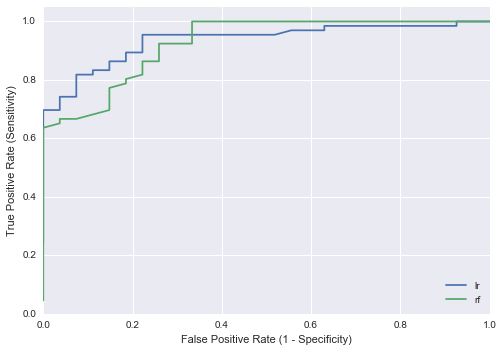

In [29]:
#generate lr model false positive and true positive rates
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, predicted_probs_lr[:,1])

#generate same for random forest model
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, predicted_probs_rf[:,1])

# plot LR and RF model ROC curves
sns.plt.plot(fpr_lr, tpr_lr,label="lr")
sns.plt.plot(fpr_rf, tpr_rf,label="rf")
sns.plt.xlim([0, 1])
sns.plt.ylim([0, 1.05])
sns.plt.legend(loc="lower right")
sns.plt.xlabel('False Positive Rate (1 - Specificity)')
sns.plt.ylabel('True Positive Rate (Sensitivity)')
# Blue line is for Logistic regression   -- we only do this on the minority class
# Green line is for random forrest       -- we only do this on the minority class

The ROC curve allows you to balance how many FN's (misses) and FP's (false alarms) you're willing to have with respect to one of your classes.

There's a metric that allows you to quantify the overall performance of your binary classifier, regardless of the threshold you choose. This metric is called the **AUC (area under the curve)**, and is a systematic way to compare two classifiers relative to each other, across all decision thresholds. If model A has a higher AUC than model B then this means that on average, model A is a better classifier across all decision thresholds (all probabilities). 

Besides allowing you to calculate AUC, seeing the ROC curve can help you to choose a threshold that **balances sensitivity and specificity** in a way that makes sense for the particular context.

In [30]:
# calculate AUC for lr and rf
print("LR model AUC: ",metrics.roc_auc_score(y_test, predicted_probs_lr[:,1]))
print("RF model AUC: ",metrics.roc_auc_score(y_test, predicted_probs_rf[:,1]))

LR model AUC:  0.935746352413
RF model AUC:  0.925084175084


Let's make this more explicit. Let's say instead of using 0.5 as the probability threshold for class 1, we want the probability threshold where the false positive rate is no higher than 12% (because additional false positives cost too much money, or time, etc.). 

Let's take a look at a graph of the ROC curve and the class 1 thresholds as a function of FPR:

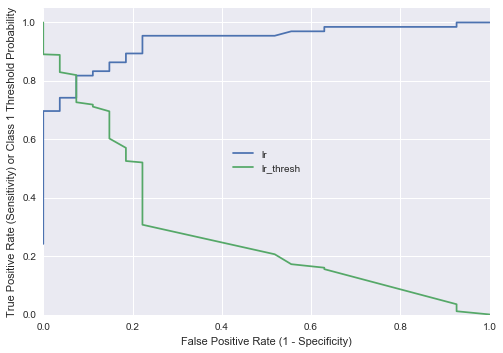

In [31]:
# plot LR and RF model ROC curves
sns.plt.plot(fpr_lr, tpr_lr,label="lr")
sns.plt.plot(fpr_lr,thresholds_lr, label="lr_thresh")
sns.plt.xlim([0, 1])
sns.plt.ylim([0, 1.05])
sns.plt.legend(loc="center")
sns.plt.xlabel('False Positive Rate (1 - Specificity)')
sns.plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability')
# The Green line is the probability line

It looks like the threshold that satisfies our criteria is ~0.7. Let's use this new threshold to generate our predictions and see what our new confusion matrix looks like:

In [32]:
y_test_lr_df["predicted_07"] = (y_test_lr_df.class_1 > 0.7).astype(float)
print(y_test_lr_df.head())
print("Confusion matrix at original 0.5 threshold:\n",metrics.confusion_matrix(y_test_lr_df.actual,
                                                                      y_test_lr_df.predicted),"\n")
print("Classification Report at original 0.5 threshold:\n", metrics.classification_report(y_test_lr_df.actual,
                                                                                          y_test_lr_df.predicted),"\n")
print("Confusion matrix at 0.7 threshold:\n",metrics.confusion_matrix(y_test_lr_df.actual,
                                                                      y_test_lr_df.predicted_07),"\n")
print("Classification Report at 0.7 threshold:\n", metrics.classification_report(y_test_lr_df.actual,
                                                                                 y_test_lr_df.predicted_07))

   class_0  class_1  predicted  actual  predicted_07
0    0.018    0.982        1.0     1.0           1.0
1    0.111    0.889        1.0     0.0           1.0
2    0.011    0.989        1.0     1.0           1.0
3    0.094    0.906        1.0     1.0           1.0
4    0.010    0.990        1.0     1.0           1.0
Confusion matrix at original 0.5 threshold:
 [[21  6]
 [ 6 60]] 

Classification Report at original 0.5 threshold:
              precision    recall  f1-score   support

        0.0       0.78      0.78      0.78        27
        1.0       0.91      0.91      0.91        66

avg / total       0.87      0.87      0.87        93
 

Confusion matrix at 0.7 threshold:
 [[24  3]
 [11 55]] 

Classification Report at 0.7 threshold:
              precision    recall  f1-score   support

        0.0       0.69      0.89      0.77        27
        1.0       0.95      0.83      0.89        66

avg / total       0.87      0.85      0.85        93



As a result, we've now increased our precision for class 1 (we are more certain someone has a back problem, when our classifier says you have a back problem), but have also lowered our recall for class 1 (now, more people with back problems will go un-identified by our classifier). The opposite occurs for precision and recall for class 0 as a result.

**So, depending on what you want to maximize or minimize for your machine learning application, your decision threshold for your (completely trained) classifier will differ.**

**One final important point about computing the AUC, you have to use the predicted probabilities, not the class labels themselves when computing an ROC curve or AUC.**

If you use y_pred_class, it will not give you an error, rather it will interpret the ones and zeros as predicted probabilities of 100% and 0%, and thus will give you incorrect results:

In [33]:
# calculate AUC using y_pred_class (producing incorrect results)
print("Wrong way to calculate LR model AUC: ",metrics.roc_auc_score(y_test, predictions_lr))
print("Wrong way to calculate RF model AUC: ",metrics.roc_auc_score(y_test, predictions_rf))

Wrong way to calculate LR model AUC:  0.843434343434
Wrong way to calculate RF model AUC:  0.809764309764


As a final way to compare the two models, let's see if we can look at each of their predicted probabilites on the test set as a function of the actual category (the target):

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b3b4790>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11b42aa90>], dtype=object)

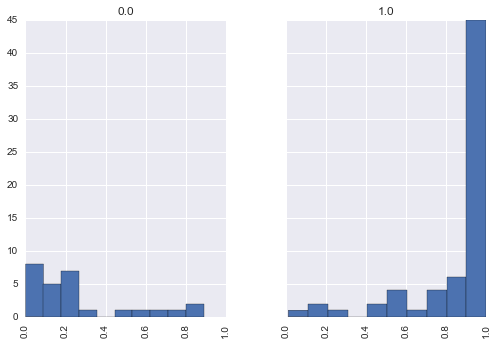

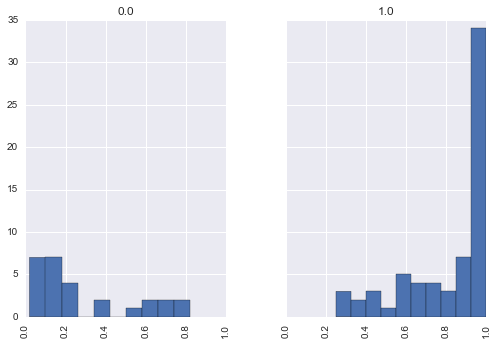

In [34]:
# histogram of predicted probabilities grouped by actual response value for LR
y_test_lr_df.class_1.hist(by= y_test_lr_df.actual, sharex=True, sharey=True)
#same for RF
y_test_rf_df.class_1.hist(by= y_test_rf_df.actual, sharex=True, sharey=True)

Depending on what threshold we choose will affect what part of each histogram consists of misclassified examples.

Nonetheless, it is fruitful at this point to examine all of those test-set samples that each classifier was "very certain" about (had very high or very low probability) but was of the wrong category (a class 0 sample that had a very high probability or a class 1 sample with a probability very close to 0).

### All that matters for ROC/AUC is the order of the probabilities, not their values

Let's go through our vertebral data example from start to finish to demonstrate a very important point:

In [35]:
#load in data
vertebral_data = pd.read_csv("../data/vertebral_column_2_categories.dat",sep=" ", 
                             names=["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle",
                                    "sacral_slope","pelvic_radius","spondy_grade","outcome"])

#convert outcome into binary 0/1 attribute
le = LabelEncoder()
vertebral_data.outcome = le.fit_transform(vertebral_data.outcome)
X = vertebral_data[vertebral_data.columns.tolist()[:-1]]
y = vertebral_data.outcome

#create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)
#create logistic regression object
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)

print("Test set accuracy of default 0.5 threshold LR model: ",metrics.accuracy_score(y_test, y_test_pred))

Test set accuracy of default 0.5 threshold LR model:  0.860215053763


(array([ 39.,   8.,   5.,   7.,   4.,   5.,   5.,   7.,  11.,   2.]),
 array([  6.81163503e-10,   9.89455425e-02,   1.97891084e-01,
          2.96836626e-01,   3.95782168e-01,   4.94727710e-01,
          5.93673252e-01,   6.92618793e-01,   7.91564335e-01,
          8.90509877e-01,   9.89455419e-01]),
 <a list of 10 Patch objects>)

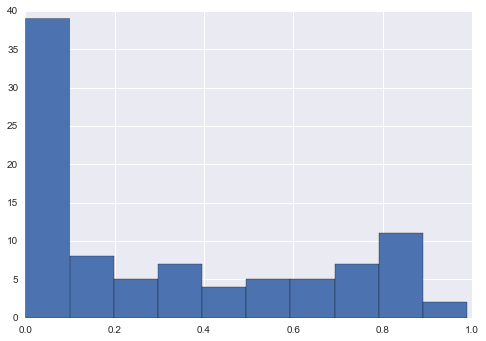

In [36]:
# calculate predicted probabilities for class 1
y_pred_prob1 = lr.predict_proba(X_test)[:, 1]
# show predicted probabilities in a histogram
sns.plt.hist(y_pred_prob1)

In [37]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob1)

0.94837261503928172

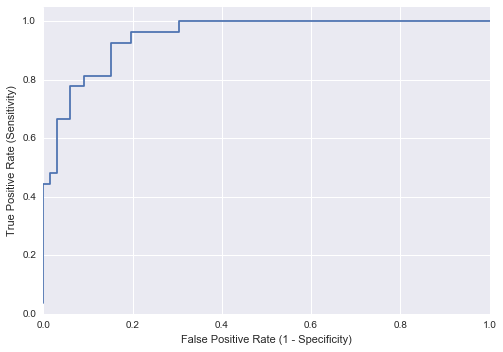

In [38]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob1)
sns.plt.plot(fpr, tpr)
sns.plt.xlim([0, 1])
sns.plt.ylim([0, 1.05])
sns.plt.xlabel('False Positive Rate (1 - Specificity)')
sns.plt.ylabel('True Positive Rate (Sensitivity)')

### First Demonstration: Take the square root of predicted probabilities (makes them all bigger, but preserve the order of probabilities)

In [39]:
# change the predicted probabilities
y_pred_prob2 = np.sqrt(y_pred_prob1)

In [40]:
# here are the old ones (y_pred_prob1)
print("Old predicted probs:\n",y_pred_prob1[:10].round(3))

Old predicted probs:
 [ 0.036  0.19   0.004  0.038  0.013  0.143  0.86   0.001  0.     0.83 ]


In [41]:
# here are the new ones (y_pred_prob2)
print("New predicted probs:\n",y_pred_prob2[:10].round(3))   # we're just scaling everything up

New predicted probs:
 [ 0.19   0.436  0.063  0.194  0.114  0.379  0.927  0.036  0.013  0.911]


(array([ 23.,  12.,   4.,   7.,   2.,   6.,   9.,   7.,  10.,  13.]),
 array([  2.60991092e-05,   9.94948629e-02,   1.98963627e-01,
          2.98432391e-01,   3.97901154e-01,   4.97369918e-01,
          5.96838682e-01,   6.96307446e-01,   7.95776210e-01,
          8.95244973e-01,   9.94713737e-01]),
 <a list of 10 Patch objects>)

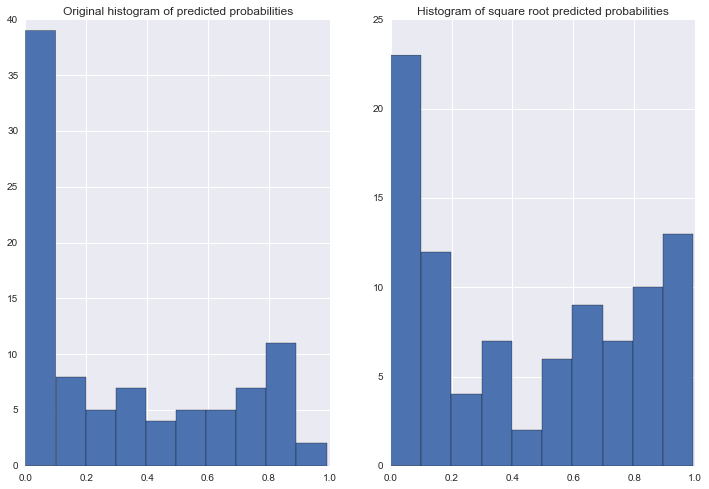

In [42]:
# you can see the histogram changed
figure = sns.plt.figure(figsize=(12,8))
figure.add_subplot(121)
sns.plt.title("Original histogram of predicted probabilities")
sns.plt.hist(y_pred_prob1)
figure.add_subplot(122)
sns.plt.title("Histogram of square root predicted probabilities")
sns.plt.hist(y_pred_prob2)

In [43]:
# the AUC did not change
print("Old AUC: ",metrics.roc_auc_score(y_test, y_pred_prob1))
print("New AUC: ",metrics.roc_auc_score(y_test, y_pred_prob2))

Old AUC:  0.948372615039
New AUC:  0.948372615039


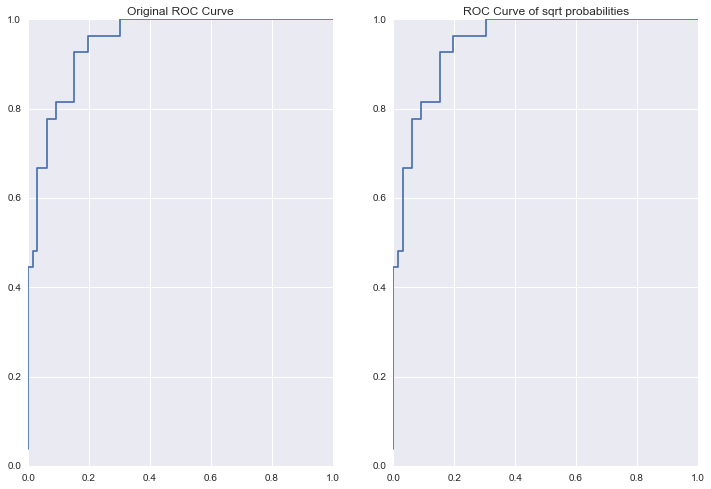

In [44]:
# the ROC curve did not change
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pred_prob2)
figure = sns.plt.figure(figsize=(12,8))
figure.add_subplot(121)
sns.plt.plot(fpr, tpr)
sns.plt.title("Original ROC Curve")
figure.add_subplot(122)
sns.plt.title("ROC Curve of sqrt probabilities")
sns.plt.plot(fpr2, tpr2)

#### Make small predicted probabilities smaller, and make big predicted probabilities bigger

In [45]:
y_pred_prob3 = np.where(y_pred_prob1 > 0.5, np.sqrt(y_pred_prob1), y_pred_prob1**2)
# you can see these are different from y_pred_prob1 and y_pred_prob2
y_pred_prob3[:10]

array([  1.31135781e-03,   3.61801998e-02,   1.58107935e-05,
         1.42373381e-03,   1.71617082e-04,   2.05432725e-02,
         9.27155665e-01,   1.60509238e-06,   2.71807198e-08,
         9.10836821e-01])

(array([ 53.,  10.,   0.,   0.,   0.,   0.,   0.,   7.,  10.,  13.]),
 array([  4.63983718e-19,   9.94713737e-02,   1.98942747e-01,
          2.98414121e-01,   3.97885495e-01,   4.97356869e-01,
          5.96828242e-01,   6.96299616e-01,   7.95770990e-01,
          8.95242363e-01,   9.94713737e-01]),
 <a list of 10 Patch objects>)

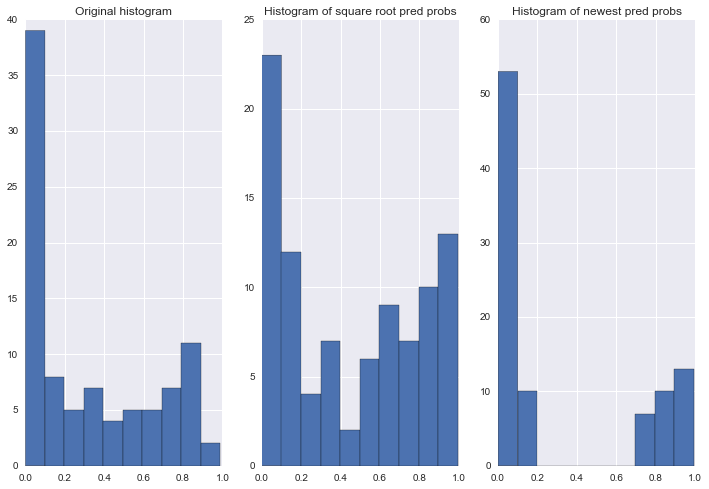

In [46]:
# the histogram changed
# you can see the histogram changed
figure = sns.plt.figure(figsize=(12,8))
figure.add_subplot(131)
sns.plt.title("Original histogram")
sns.plt.hist(y_pred_prob1)
figure.add_subplot(132)
sns.plt.title("Histogram of square root pred probs")
sns.plt.hist(y_pred_prob2)
figure.add_subplot(133)
sns.plt.title("Histogram of newest pred probs")
sns.plt.hist(y_pred_prob3)

In [47]:
# the AUC did not change
print("Original AUC: ",metrics.roc_auc_score(y_test, y_pred_prob1))
print("Square root probs AUC: ",metrics.roc_auc_score(y_test, y_pred_prob2))
print("Newest transformed AUC: ",metrics.roc_auc_score(y_test, y_pred_prob3))

Original AUC:  0.948372615039
Square root probs AUC:  0.948372615039
Newest transformed AUC:  0.948372615039


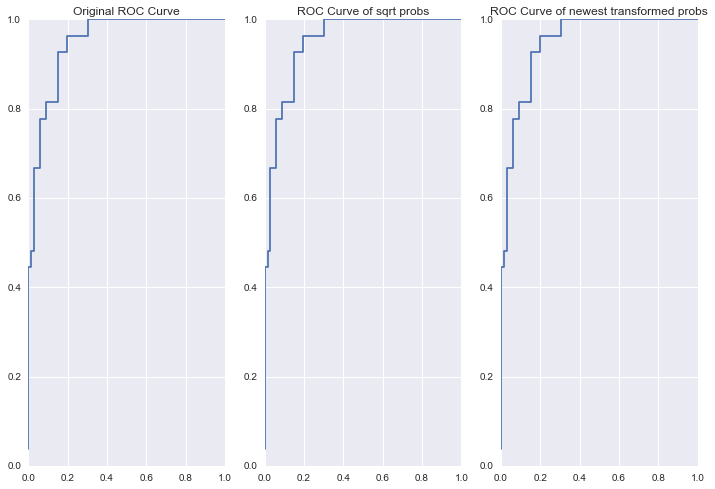

In [48]:
fpr3, tpr3, thresholds2 = metrics.roc_curve(y_test, y_pred_prob3)
# the ROC curve did not change
figure = sns.plt.figure(figsize=(12,8))
figure.add_subplot(131)
sns.plt.plot(fpr, tpr)
sns.plt.title("Original ROC Curve")
figure.add_subplot(132)
sns.plt.title("ROC Curve of sqrt probs")
sns.plt.plot(fpr2, tpr2)
figure.add_subplot(133)
sns.plt.title("ROC Curve of newest transformed probs")
sns.plt.plot(fpr3, tpr3)

The point of all of this is, as long as the ordering of probabilities for all of your samples is maintained, the ROC will remain identical.

All that matters is the order of the predicted probabilities in predicted data, not the actual values!

### ROC/Confusion Matrix/Metric Takeaways

* For binary classifiers, you want to have the highest AUC possible. To decide between two classifiers, maximize the one that has the higher AUC.
* Once you've maximized your AUC, you set about choosing your classifier threshold based on the specifics of your problem. If you need to minimize false alarms (so maximize precision) while keeping your recall some acceptable level, then you do one thing. If you need to maximize accuracy, you do something else.
* In every case, what you're doing is generating a threshold from a specific point on the ROC curve.

## Precision Recall Curve

In [49]:
from sklearn.metrics import precision_recall_curve

In [50]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob1)

In [51]:
threshold

array([ 0.19021094,  0.19925413,  0.24783173,  0.25653684,  0.27909834,
        0.28898041,  0.31359997,  0.3289718 ,  0.36066945,  0.37794793,
        0.38157867,  0.38404708,  0.38525142,  0.41449365,  0.41653201,
        0.42464124,  0.43822909,  0.50980184,  0.52612139,  0.54574338,
        0.57091813,  0.57274158,  0.62566351,  0.62742404,  0.65497284,
        0.66153522,  0.67458995,  0.69285158,  0.72126671,  0.74924323,
        0.76149407,  0.77488826,  0.77700553,  0.78634557,  0.81044311,
        0.81866418,  0.82962371,  0.83830645,  0.83902149,  0.85961763,
        0.86107361,  0.87745941,  0.87847689,  0.88550829,  0.88624504,
        0.9518524 ,  0.98945542])

In [52]:
recall

array([ 1.        ,  0.96296296,  0.96296296,  0.96296296,  0.96296296,
        0.96296296,  0.96296296,  0.96296296,  0.96296296,  0.92592593,
        0.92592593,  0.92592593,  0.92592593,  0.88888889,  0.85185185,
        0.81481481,  0.81481481,  0.81481481,  0.81481481,  0.81481481,
        0.77777778,  0.77777778,  0.77777778,  0.74074074,  0.7037037 ,
        0.66666667,  0.66666667,  0.66666667,  0.62962963,  0.59259259,
        0.55555556,  0.51851852,  0.48148148,  0.48148148,  0.44444444,
        0.44444444,  0.40740741,  0.37037037,  0.33333333,  0.2962963 ,
        0.25925926,  0.22222222,  0.18518519,  0.14814815,  0.11111111,
        0.07407407,  0.03703704,  0.        ])

In [53]:
precision

array([ 0.57446809,  0.56521739,  0.57777778,  0.59090909,  0.60465116,
        0.61904762,  0.63414634,  0.65      ,  0.66666667,  0.65789474,
        0.67567568,  0.69444444,  0.71428571,  0.70588235,  0.6969697 ,
        0.6875    ,  0.70967742,  0.73333333,  0.75862069,  0.78571429,
        0.77777778,  0.80769231,  0.84      ,  0.83333333,  0.82608696,
        0.81818182,  0.85714286,  0.9       ,  0.89473684,  0.88888889,
        0.88235294,  0.875     ,  0.86666667,  0.92857143,  0.92307692,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ])

(0, 1)

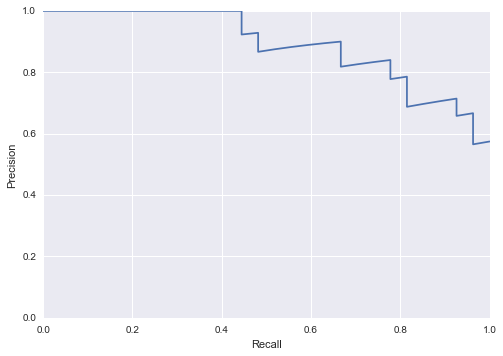

In [54]:
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0,1])
plt.ylim([0,1])

### Pipelines: Putting An Entire Model Together End to End

Ok, the last thing we are going to learn how to do, is how to combine every aspect creating and using a supervised machine learning model:

1. Transforming your original data (removing skew, standard scaling, encoding categorical variables as numbers)
2. Training and validating a model on that data
3. Picking parameters for a given model to optimize accuracy/precision/recall/f1 score, etc.

Let's try to see how we would do this without a pipeline. Let's get some data:

In [55]:
columns = ["sex","length","diam","height","whole","shucked","viscera","shell","age"]  # age is the target 
# we're trying to predict the age of the fish given all of these other parameters
numeric_columns = columns[1:-1]
categorical_columns = columns[0]
target = columns[-1]

abalone_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data",names=columns)
abalone_data.head()

,sex,length,diam,height,whole,shucked,viscera,shell,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Now let's preprocess it in the standard way I've shown you:

1. Let's convert the categorical column using one-hot encoding
2. Standard scale (Z-score) the numeric columns

In [56]:
#get categorical features
#drop off last column because its unnecessary
X_categorical = pd.get_dummies(abalone_data[categorical_columns]).astype(int).ix[:,:-1]

#get and transform numeric features
X_numeric = abalone_data[numeric_columns]
X_numeric[numeric_columns] = StandardScaler().fit_transform(X_numeric)

#get outcome variable
y = abalone_data[target]

#combine transformed categorical and numeric features
X_final = pd.concat((X_numeric,X_categorical),axis=1)

And now, let's do our standard 10-fold cross-validation scoring:

In [57]:
#create rf regressor and check 10-fold RMSE -- we're all doing this manually here
rf = RandomForestRegressor()
cross_val_scores = np.abs(cross_val_score(rf,X_final,y,scoring = "mean_squared_error", cv=10))
rmse_cross_val_scores = np.sqrt(cross_val_scores)
print("Mean 10-fold rmse: ", np.mean(rmse_cross_val_scores))
print("Std 10-fold rmse: ", np.std(rmse_cross_val_scores))

Mean 10-fold rmse:  2.25645781399
Std 10-fold rmse:  0.616334131631


Now, we are going to do the same thing using Scikit-learn's pipeline feature. First, we are going to have a class that allows us to subselect columns that we want to work with:

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to sklearn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

Now, we are going to make the full pipeline, from start to finish, for the entire dataset:

In [59]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder

#encode the categorical column from strings to ints
le = LabelEncoder()
abalone_data["sex_encoded"] = abalone_data[[categorical_columns]].apply(le.fit_transform)

#extract the y
y = abalone_data.age

#create the feature union for the features
X_transformed_pipe = FeatureUnion(
        transformer_list=[
            # Pipeline for one hot encoding categorical column
            ('sexes', Pipeline([
                ('selector', ItemSelector(key=["sex_encoded"])),    # each step of the pipeline has a name
                ('encoder', OneHotEncoder())         # get dummies here ...           
            ])),
            # Pipeline for pulling out numeric features and scaling them
            ('numeric', Pipeline([
                ('selector', ItemSelector(key=numeric_columns)), # we're selecting all the numerical columns
                ('polyfeatures', PolynomialFeatures(degree=2,interaction_only=True)),
                ('scaler', StandardScaler()),
            ]))])   # feature union step(s)
#create the full final pipeline
full_pipeline = Pipeline([("all_features",X_transformed_pipe),("rf_regressor",RandomForestRegressor(n_estimators=100))])

And now let's run the whole pipe through the `cross_val_score` object:

In [60]:
#pass the pipeline directly into cross_val_score
cross_val_scores = np.abs(cross_val_score(full_pipeline,abalone_data,y,cv=10,scoring="mean_squared_error"))
rmse_cross_val_scores = np.sqrt(cross_val_scores)
print("Mean 10-fold rmse: ", np.mean(rmse_cross_val_scores))   # it does 10-fold cross-validation
print("Std 10-fold rmse: ", np.std(rmse_cross_val_scores))   
# It's slow because it's building thousands of trees

Mean 10-fold rmse:  2.15152214857
Std 10-fold rmse:  0.619219232462


#### Exercise Time!

* Change the pipeline to perform PCA and keep only the first 6 components on the complete feature pipe (after standard scaling numeric features and encoding the categorical feature)

In [ ]:
pass

Now let's do this on a slightly more involved example, where we will have to do some imputation (filling in of missing values).

Here the process will be as follows:

1. Encode categorical string columns as numbers using `LabelEncoder`
2. Impute missing categorical values (marked with 0 after encoding) with most frequent category using `Imputer`
3. One-hot encode the categorical columns using `OneHotEncoder`
4. Impute missing numerical values using the median value of each column using `Imputer`
5. Z-score/standardize each numerica column using `StandardScaler`
6. Combine both collections of columns (one-hot encoded categorical columns and standardized numeric columns) using `FeatureUnion`
7. Pass the whole collection to a `RandomForestClassifier` to build a Random Forest classification model.
8. Use `cross_val_score` with 10-fold cross-validation on the entire pipeline.

Ready? Let's start by loading in the data:

In [ ]:
kidney_columns = ["age","bp","sg","al","su","rbc","pc","pcc","ba","bgr","bu","sc","sod","pot","hemo","pcv","wc","rc","htn","dm","cad","appet","pe","ane","class"]
kidney_data = pd.read_csv("../data/chronic_kidney_disease.csv",header=None,na_values="?",names=kidney_columns)
kidney_data.head()

Let's rearrange the columns so that the numeric columns are together, followed by all of the categorical columns:

In [ ]:
#rearrange kidney columns as before
kidney_columns = kidney_columns[:5]+kidney_columns[9:18]+kidney_columns[5:9]+kidney_columns[18:]
kidney_data = kidney_data[kidney_columns]
kidney_data.head()

Let's encode the strings as numbers:

In [ ]:
kidney_columns[14:]

In [ ]:
kidney_data.info()

In [ ]:
#convert strings to numbers
le = LabelEncoder()
kidney_data[kidney_columns[14:]] = kidney_data[kidney_columns[14:]].fillna("").apply(le.fit_transform)
#get the X and y
X = kidney_data[kidney_columns[:-1]]
y = kidney_data["class"]
kidney_data.head()

And here is the code for the entire pipeline:

In [ ]:
from sklearn.preprocessing import Imputer

X_transformed_pipe = FeatureUnion(
        transformer_list=[
            # Pipeline for filling in missing values, one hot encoding all categorical columns
            ('categoricals', Pipeline([
                ('selector', ItemSelector(key=kidney_columns[14:-1])),
                ('imputer', Imputer(missing_values=0,strategy="most_frequent",axis=0)),
                ('encoder', OneHotEncoder())                    
            ])),
            # Pipeline for pulling out numeric features, filling in missing values, and scaling them
            ('numeric', Pipeline([
                ('selector', ItemSelector(key=kidney_columns[:14])),
                ('imputer', Imputer(strategy="median",axis=0)),
                ('scaler', StandardScaler()),
            ]))])

full_pipeline = Pipeline([("all_features",X_transformed_pipe),("rf_classifier",RandomForestClassifier())])

In [ ]:
cross_val_score(full_pipeline,X,y,cv=10)

Each pipeline object contains a sequence of steps, which are stored in a list. Each step is a tuple, where the first element is the name you gave the given step, and the second element is the transformation or model you are applying at that step:

In [ ]:
full_pipeline.steps

Let's take a look at a few steps:

In [ ]:
full_pipeline.steps[1][1]

In [ ]:
print("The first step in the pipeline:\n",full_pipeline.steps[0])
print()
print("The second step in the pipeline: \n", full_pipeline.steps[1])
print()
print("The second step's transformation/model:\n", full_pipeline.steps[1][1])
print("Since we know this is a random forest model, lets try to get the models feature importances:\n",full_pipeline.steps[1][1].feature_importances_)

Remember, in order to be able to get feature importances or coefficients of a given model, it needs to be trained first. Just like any other transformation in sklearn, you can fit a pipeline by calling its `fit` method:

In [ ]:
full_pipeline.fit(X,y)

Now that it's been fit, we can extract the feature importances as we wanted:

In [ ]:
full_pipeline.steps[1][1].feature_importances_.round(3)

What's really great about pipelines is that you can even put them into `GridSearchCV` methods, and search across parameters to tune your models. To do so, create a dictionary entry in `param_grid` that names the step (which you named earlier) and parameters you want to test:

In [ ]:
# using GridSearchCV with Pipeline
from sklearn.grid_search import GridSearchCV
estimators_range = [20,50,100]
param_grid = dict(rf_classifier__n_estimators=estimators_range)
grid = GridSearchCV(full_pipeline, param_grid, cv=20, scoring='accuracy',n_jobs=-1)
grid.fit(X, y)
print("Best cross-validated accuracy: ",grid.best_score_)
print("Best parameter found: ",grid.best_params_)
print("Fitted_model: ",grid.best_estimator_.steps[1][1])

#### Exercise Time!

* add a PCA transformation step before training the classifier
* search over the number of PCA components to keep using `GridSearchCV` (test whether to keep the first 5,10, or all components)

In [ ]:
pass